In [1]:
!pip install gensim --upgrade

# Задание 1

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
wiki = open('wiki_data.txt', encoding='utf-8').read().split('\n')

In [3]:
data = pd.read_csv('labeled.csv')

In [4]:
all_data = wiki

In [5]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(all_data)
X_svd = svd.fit_transform(X)

In [6]:
embeddings = svd.components_.T

In [7]:
from pymystem3 import Mystem
m = Mystem()

In [9]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-01-27 10:19:32--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.243, 5.45.205.241, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.243|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2022-01-27 10:19:33--  http://cache-man01i.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)... 5.45.205.221, 2a02:6b8::3:221
Connecting to cache-man01i.cdn.yandex.net (cache-man01i.cdn.yandex.net)|5.45.205.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.2’

mystem-3.0-linux3.1 100%[===================>]  15.70M 

In [8]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [9]:
def preprocess(text):
    tokens = []

    text = text.strip(punctuation)
    words = m.analyze(text)

    for word in words:
      if 'analysis' not in word:
        continue
      


      #print(word)
      lemma = word["text"] if not word["analysis"] else word["analysis"][0]["lex"]
      tokens.append(lemma.lower().strip())
    return tokens

In [10]:
from tqdm import tqdm

In [11]:
def preprocess_data(data, filter=30):
  vocab = Counter()

  for text in data:
      vocab.update(preprocess(text))
      
  filtered_vocab = set()

  for word in vocab:
      if vocab[word] > filter:
          filtered_vocab.add(word)

  word2id = { 'PAD':0}

  for word in filtered_vocab:
      word2id[word] = len(word2id)
  id2word = {i:word for word, i in word2id.items()}

  return word2id, id2word  

In [12]:
def make_X(data, word2id):
  X = []

  for text in data:
      tokens = preprocess(text)
      ids = [word2id[token] for token in tokens if token in word2id]
      X.append(ids)

  return X

In [13]:
def get_random_weighted_vals(X, word2id):
  zero_arr = np.zeros(sum([len(x) for x in X]))
  rand_arr = [word2id[WeightedPick(word2id)] for x in zero_arr]
  return rand_arr

In [14]:
import random

def WeightedPick(d):
    r = random.uniform(0, sum(d.values()))
    s = 0.0
    for k, w in d.items():
        s += w
        if r < s: return k
    return k

In [15]:
def gen_batches_sg(sentences, rand_ids, window = 12, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)):
                word = sent[i]
                left = max(0, i - window)
                right = window - left + 1
                context = sent[left:i] + sent[i+1:right]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(rand_ids[sentences.index(sent) + i])
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [16]:
def gen_batches_cbow(sentences, rand_ids, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                left = max(0, i - window)
                right = window - left + 1
                context = sent[left:i] + sent[i+1:right]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(rand_ids[sentences.index(sent) + i])
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [17]:
def fit_negative_sg(X_train, y_train, X_valid, y_valid, len_v):
  inputs_target = tf.keras.layers.Input(shape=(1,))
  inputs_context = tf.keras.layers.Input(shape=(1,))


  embeddings_target = tf.keras.layers.Embedding(input_dim=len_v, output_dim=300)(inputs_target, )
  embeddings_context = tf.keras.layers.Embedding(input_dim=len_v, output_dim=300)(inputs_context, )

  target = tf.keras.layers.Flatten()(embeddings_target)
  context = tf.keras.layers.Flatten()(embeddings_context)

  dot = tf.keras.layers.Dot(1)([target, context])
  outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

  model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.fit(gen_batches_sg(X_train, y_train),
          validation_data=gen_batches_sg(X_valid, y_valid),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)
  return model

In [18]:
def fit_negative_cbow(X_train, y_train, X_valid, y_valid, len_v):
  #cbow negative sampling
  inputs_target = tf.keras.layers.Input(shape=(1,))
  inputs_context = tf.keras.layers.Input(shape=(10,))


  embeddings_target = tf.keras.layers.Embedding(input_dim=len_v, output_dim=300)(inputs_target, )
  embeddings_context = tf.keras.layers.Embedding(input_dim=len_v, output_dim=300)(inputs_context, )

  target = tf.keras.layers.Flatten()(embeddings_target)
  context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
  dot = tf.keras.layers.Dot(1)([target, context])

  # полученную близость нужно преобразовать в вероятность
  # когда она одна используется не софтмакс и сигмоида
  outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

  model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)


  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.fit(gen_batches_cbow(X_train, y_train),
          validation_data=gen_batches_cbow(X_valid, y_valid),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)
  return model

In [19]:
def get_train_valid(data):
  print('start')
  word2id, id2word = preprocess_data(data)
  X = make_X(data, word2id)

  X_train = X[:int(len(X)*0.8)]
  X_valid = X[int(len(X)*0.8):]
  y_train = get_random_weighted_vals(X_train, word2id)
  y_valid = get_random_weighted_vals(X_valid, word2id)
  print('got data')
  return X_train, y_train, X_valid, y_valid, word2id, id2word

In [20]:
X_train, y_train, X_valid, y_valid, word2id, id2word = get_train_valid(all_data)

start
got data


In [21]:
model_sg = fit_negative_sg(X_train, y_train, X_valid, y_valid, len(word2id))

Epoch 1/2
10000/10000 [==============================] - 910s 91ms/step - loss: 0.3728 - accuracy: 0.9081 - val_loss: 1.4441 - val_accuracy: 0.5681
Epoch 2/2
10000/10000 [==============================] - 925s 93ms/step - loss: 0.4339 - accuracy: 0.9100 - val_loss: 2.2900 - val_accuracy: 0.5837


In [22]:
model_cbow = fit_negative_cbow(X_train, y_train, X_valid, y_valid, len(word2id))

Epoch 1/2
5000/5000 [==============================] - 819s 164ms/step - loss: 0.1993 - accuracy: 0.9260 - val_loss: 1.0630 - val_accuracy: 0.6488
Epoch 2/2
5000/5000 [==============================] - 890s 178ms/step - loss: 0.1667 - accuracy: 0.9372 - val_loss: 1.1732 - val_accuracy: 0.6690


In [23]:
(most_similar("церковь", model_sg.layers[2].get_weights()[0]), most_similar("церковь", model_cbow.layers[2].get_weights()[0]))

(['церковь',
  'округ',
  'тело',
  'ход',
  'руководитель',
  'уходить',
  'начало',
  'не',
  'начинаться',
  'впоследствии'],
 ['церковь',
  'дом',
  'местный',
  'житель',
  'мать',
  'оно',
  'xx',
  'семья',
  'перенести',
  'каменный'])

In [24]:
most_similar("газета", model_sg.layers[2].get_weights()[0]), most_similar("газета", model_cbow.layers[2].get_weights()[0])

(['газета',
  'цель',
  'богоматерь',
  'попытаться',
  'бороться',
  'победитель',
  'л',
  'будущий',
  'сын',
  'храм'],
 ['газета',
  'семья',
  'июнь',
  'местный',
  'решение',
  'академия',
  'дело',
  'выражать',
  'выходить',
  'сотрудник'])

In [25]:
most_similar("капитуляция", model_sg.layers[2].get_weights()[0]), most_similar("капитуляция", model_cbow.layers[2].get_weights()[0])

(['капитуляция',
  'связанный',
  'необходимо',
  'английский',
  'захватить',
  'наименование',
  'сезон',
  'будущий',
  'борьба',
  'налог'],
 ['капитуляция',
  'командование',
  'сформировывать',
  'полковник',
  'лагерь',
  'капитан',
  'генерал-майор',
  'артиллерийский',
  'германский',
  'взятие'])

Можно увидеть, что в целом модели получились не совсем хорошими, но какое-то слово, похожее по смыслу можно найти в выдаче. Стоит отметить, что модель cbow выдаёт лучше результаты.

# Задание 2

In [26]:
import gensim

In [27]:
texts = [preprocess(text) for text in all_data]

In [28]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=300, 
                             min_count=50, 
                             max_vocab_size=100000,
                             window=8,
                             sg=1,
                             workers=2,
                             seed=2,
                             epochs=7,
                             hs=1,
                             cbow_mean=0
                             )

In [ ]:
w2v.wv.most_similar('церковь')

In [29]:
ft = gensim.models.FastText(texts, window=7, min_alpha=0.001, min_n=1, max_n=6, vector_size=300)

In [33]:
w2v.wv.most_similar('церковь'), ft.wv.most_similar('церковь')

([('храм', 0.7494755983352661),
  ('собор', 0.7134344577789307),
  ('православный', 0.7000914812088013),
  ('святой', 0.6768147945404053),
  ('освящать', 0.6725195646286011),
  ('часовня', 0.6371599435806274),
  ('католический', 0.6305620074272156),
  ('пресвятой', 0.6253577470779419),
  ('прихожанин', 0.6206818222999573),
  ('монастырь', 0.6084731221199036)],
 [('церковь#', 0.970466136932373),
  ('морковь', 0.8428837060928345),
  ('монастырь', 0.8399038314819336),
  ('церковный', 0.8177922964096069),
  ('храм', 0.8107518553733826),
  ('монастырь#', 0.7995739579200745),
  ('архипастырь', 0.78423011302948),
  ('пастырь', 0.7710403800010681),
  ('собор', 0.770180881023407),
  ('монастырская', 0.7668732404708862)])

In [31]:
w2v.wv.most_similar('газета'), ft.wv.most_similar('газета')

([('редактор', 0.6380631327629089),
  ('журнал', 0.6210442781448364),
  ('корреспондент', 0.5766292214393616),
  ('публиковаться', 0.5484575629234314),
  ('печататься', 0.5384432077407837),
  ('издаваться', 0.5344370007514954),
  ('общественно-политический', 0.5314157009124756),
  ('издание', 0.5269787907600403),
  ('известие', 0.5180867314338684),
  ('новость', 0.5020334720611572)],
 [('журнал', 0.7429567575454712),
  ('газель', 0.6913561224937439),
  ('госкомиздат', 0.6843876838684082),
  ('гагауз', 0.6794601082801819),
  ('газа', 0.6778537034988403),
  ('издатель', 0.6720065474510193),
  ('изда', 0.664497971534729),
  ('журналистка', 0.6628860831260681),
  ('издавна', 0.6565166711807251),
  ('газетный', 0.6531410217285156)])

In [32]:
w2v.wv.most_similar('капитуляция'), ft.wv.most_similar('капитуляция')

([('подписание', 0.43641525506973267),
  ('войско', 0.4343109428882599),
  ('сдаваться', 0.42240387201309204),
  ('перемирие', 0.4205203652381897),
  ('плен', 0.41508400440216064),
  ('вторжение', 0.3960152268409729),
  ('наступление', 0.3832736611366272),
  ('француз', 0.38060662150382996),
  ('переговоры', 0.38037028908729553),
  ('японец', 0.3763851225376129)],
 [('манипуляция', 0.8640726208686829),
  ('коагуляция', 0.8625158667564392),
  ('капитализация', 0.8548827171325684),
  ('апелляция', 0.8481954336166382),
  ('контрибуция', 0.8466829657554626),
  ('конспирация', 0.8465123176574707),
  ('триангуляция', 0.8454871773719788),
  ('интабуляция', 0.843769371509552),
  ('корреляция', 0.8426873087882996),
  ('имплантация', 0.8405661582946777)])

Видно, что модели gensim работают намного лучше моделей, основанных на работе tensorflow.

# Задание 3

In [34]:
word2id, id2word = preprocess_data(data.comment, 5)
X = make_X(data.comment, word2id)

In [35]:
len_dim = 300

In [36]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=len_dim)
y = data.toxic.values

In [37]:
def fit_model(X_train, y_train, X_valid, y_valid, len_v, weights, len_dim=100):
  inputs = tf.keras.layers.Input(shape=(len_dim,))

  # передаем матрицу в эмбединг слой
  # указываем параметр trainable=False, чтобы вектора не обучались
  # Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
  # эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
  # обучатся заново
  embeddings = tf.keras.layers.Embedding(input_dim=len_v, output_dim=len_dim, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
  mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)
  return model

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [39]:
def calculate_weights(word2id, len_dim, embeddings, tf=True, preload=False):
  weights = np.zeros((len(word2id), len_dim))

  for word, i in word2id.items():
      # вектор паддинга оставим нулевым
      if word == 'PAD':
          continue

      try:
          weights[i] = embeddings[word2id[word]] if tf else embeddings[word] if not preload else embeddings(word)
      
      
      except KeyError:
          # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
          continue
          weights[i] = embeddings['опрагпллирао']

  return weights

In [40]:
models = []
list_weights = []

In [41]:
list_weights.append(calculate_weights(word2id, model_sg.layers[2].get_weights()[0].shape[1], model_sg.layers[2].get_weights()[0]))

In [42]:
list_weights.append(calculate_weights(word2id, len_dim, model_cbow.layers[2].get_weights()[0]))

In [43]:
list_weights.append(calculate_weights(word2id, len_dim, ft.wv, False))

In [44]:
list_weights.append(calculate_weights(word2id, len_dim, w2v.wv, False))

In [45]:
for weights in list_weights:
  models.append(fit_model(X_train, y_train, X_valid, y_valid, len(word2id), weights, weights.shape[1]))

Epoch 1/30
428/428 [==============================] - 3s 5ms/step - loss: 0.6598 - accuracy: 0.6650 - val_loss: 0.6363 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6360 - accuracy: 0.6650 - val_loss: 0.6259 - val_accuracy: 0.6685
Epoch 3/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6327 - accuracy: 0.6650 - val_loss: 0.6239 - val_accuracy: 0.6685
Epoch 4/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6322 - accuracy: 0.6650 - val_loss: 0.6233 - val_accuracy: 0.6685
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6321 - accuracy: 0.6650 - val_loss: 0.6232 - val_accuracy: 0.6685
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6320 - accuracy: 0.6650 - val_loss: 0.6230 - val_accuracy: 0.6685
Epoch 7/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6319 - accuracy: 0.6650 - val_loss: 0.6229 - val_accuracy: 0.6685
Epoch 

In [46]:
def show_model_plots(models):
  for model in models:
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [47]:
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [48]:
m = Mystem()

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [49]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [50]:
data['norm_data'] = data.comment.apply(normalize_mystem)
word2id, id2word = preprocess_data([' '.join(sent) for sent in data['norm_data']], 5)
X = make_X([' '.join(sent) for sent in data['norm_data']], word2id)

In [51]:
weights = calculate_weights(word2id, len_dim, model.word_vec, False, True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  # Remove the CWD from sys.path while we load stuff.


In [52]:
models.append(fit_model(X_train, y_train, X_valid, y_valid, len(word2id), weights, weights.shape[1]))

Epoch 1/30
428/428 [==============================] - 3s 7ms/step - loss: 0.6686 - accuracy: 0.6650 - val_loss: 0.6510 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6452 - accuracy: 0.6650 - val_loss: 0.6389 - val_accuracy: 0.6685
Epoch 3/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6391 - accuracy: 0.6650 - val_loss: 0.6360 - val_accuracy: 0.6685
Epoch 4/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6379 - accuracy: 0.6650 - val_loss: 0.6354 - val_accuracy: 0.6685
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6377 - accuracy: 0.6650 - val_loss: 0.6353 - val_accuracy: 0.6685
Epoch 6/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6377 - accuracy: 0.6650 - val_loss: 0.6353 - val_accuracy: 0.6685
Epoch 7/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6377 - accuracy: 0.6650 - val_loss: 0.6353 - val_accuracy: 0.6685
Epoch 

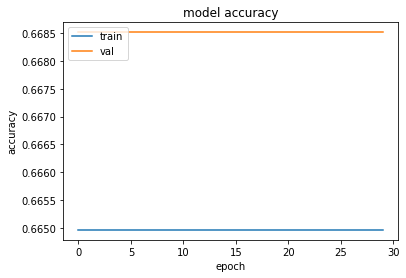

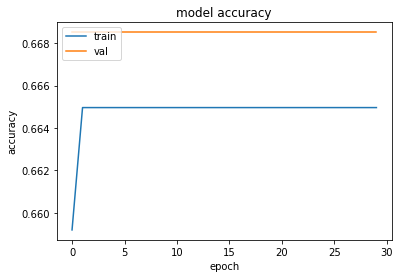

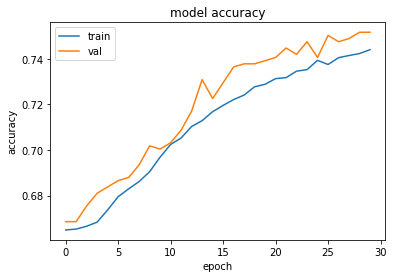

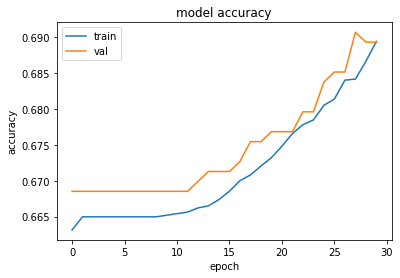

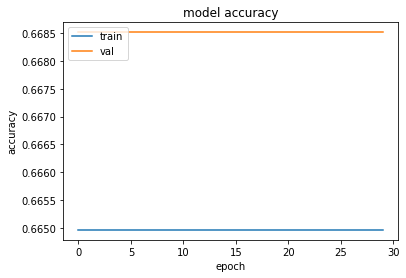

In [53]:
show_model_plots(models)

1 график - skipgram,

2 график - cbow,

3 график - fasttext,

4 график - word2vec

Судя по графикам наилучшим образом себя показывает модель fasttext. Вероятно, чтобы увеличить качество моделей, нужно настроить параметры другим образом и к датасету с вики добавить датасет с комментариями. В таком случае качество может повыситься на несколько раз.